In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random

import os
import torch
import torch.nn as nn
import torch.distributions as distributions
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.nn import functional as F
from scipy.stats import multivariate_normal
from State_Space_Model import Stochastic_AD_System
from flow_models import RealNVP, Flow_based_Bayesian_Filter, MLP
from torch.utils.data import TensorDataset
from tqdm import tqdm, trange

torch.manual_seed(1226)
np.random.seed(1226)
device = torch.device("cuda:0")

######################################
########## dataset parameters ########
######################################
# Parameters
L = 1.0               # Length of the domain
T = 1.0             # Total simulation time
k = 1               # Reaction coefficient
D = 0.1               # Diffusion coefficient

Nx = 100               # Number of spatial grid points
Nt = 200             # Number of time steps
params_dict = {"L": L, "T": T, "D": D, "k": k, "Nx": Nx, "Nt": Nt}

sigma = 10
r2 = 0.25
N_s = 10
obs_type = "PN"

if N_s == 20:
    sensor_index = np.arange(2, Nx, 5)
elif N_s == 15:
    sensor_index = np.arange(0, Nx, 7)
elif N_s == 10:
    sensor_index = np.arange(5, Nx, 10)
elif N_s == 25:
    sensor_index = np.arange(0, Nx, 4)

N_train = 1000
N_test = 200

dataFolderName = './Data/'
dataFileName = 'SAD_s={:.1f}_m={}_T={}.npy'.format(sigma, Nx, Nt)
data_filename = dataFolderName + dataFileName

In [2]:
######################################
############# Load Dataset ###########
######################################     
SAD = Stochastic_AD_System(params_dict, sigma, obs_type, sensor_index)
x_train, x_test = np.load(data_filename, allow_pickle=True)

if not os.path.exists('./models'):
    os.mkdir('./models')

model_path = './models/'+'FBF_'+ dataFileName[0:-4] + '_r2={}_i={}'.format(r2, N_s)
if not os.path.exists(model_path):
    os.mkdir(model_path)
    
obs_noise = np.load('./Data/obs_noise_r2={}.npz'.format(r2))
obs_noise_trn = obs_noise['train']
obs_noise_test = obs_noise['test']

############################################
############# Prepare Dataloader ###########
############################################  
y_train = SAD.h(x_train, SAD.obs_type)[..., sensor_index] + obs_noise_trn[..., sensor_index]
y_test = SAD.h(x_test, SAD.obs_type)[..., sensor_index] + obs_noise_test[..., sensor_index]

print("x train size:", x_train.shape)
print("y train size:", y_train.shape)
print("x test size:", x_test.shape)
print("y test size:", y_test.shape)

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
# to avoid numerical issues
x_train[..., 0] = x_train[..., 0] + 1e-5 * torch.randn([N_train, Nt])  
x_train[..., -1] = x_train[..., -1] + 1e-5 * torch.randn([N_train, Nt])
x_test[..., 0] = x_test[..., 0] + 1e-5 * torch.randn([N_test, Nt])
x_test[..., -1] = x_test[..., -1] + 1e-5 * torch.randn([N_test, Nt])

batch_size_train = 64
batch_size_test = 64
train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size_train, 
                                           shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size_test,
                                           shuffle=True, drop_last=True)

x train size: (1000, 200, 100)
y train size: (1000, 200, 10)
x test size: (200, 200, 100)
y test size: (200, 200, 10)


In [4]:
###################### Build FBF Model ######################
n_epochs = 1000
arch_params = {"Tx_units": 128, "Tx_layers": 6, "Ty_units": 128, "Ty_layers": 6, 
               "A_net_units": 128, "A_net_layers": 6, "B_net_units": 128, "B_net_layers": 6}
model = Flow_based_Bayesian_Filter(arch_params, SAD.m, N_s, train_loader, test_loader, device)
model.FBF_compile(n_epochs)

###################### Train FBF Model ######################
try:
    optimal_loss = float('inf')
    start_time = time.time()

    for epoch in range(n_epochs):
        model.train(epoch, device)
        model.test(epoch, device)

        if optimal_loss > model.loss_test[-1]:
            optimal_loss = model.loss_test[-1]
            model.save_model(model_path)
        model.scheduler.step()
        
except KeyboardInterrupt:
    pass
finally:
    print("==> Best test loss: %.6f" % (optimal_loss))
    print("Time elapsed:", time.time() - start_time)

==> Epoch: 0
Average train loss: 5992.004853,	 loss state: 5966.832787,	 loss obs: 25.172153
Average train loss: 499.299347,	 loss state: 475.087952,	 loss obs: 24.211405
==> Epoch: 1
Average train loss: 416.450779,	 loss state: 392.805299,	 loss obs: 23.645482
Average train loss: 67.235273,	 loss state: 44.368546,	 loss obs: 22.866727
==> Epoch: 2
Average train loss: 64.484862,	 loss state: 42.212477,	 loss obs: 22.272385
Average train loss: 46.564373,	 loss state: 25.143644,	 loss obs: 21.420730
==> Epoch: 3
Average train loss: 27.920776,	 loss state: 7.263030,	 loss obs: 20.657747
Average train loss: 17.504981,	 loss state: -2.204386,	 loss obs: 19.709367
==> Epoch: 4
Average train loss: 11.564015,	 loss state: -7.665057,	 loss obs: 19.229072
Average train loss: 6.257681,	 loss state: -12.429548,	 loss obs: 18.687229
==> Epoch: 5
Average train loss: 2.964338,	 loss state: -15.520101,	 loss obs: 18.484439
Average train loss: -0.692490,	 loss state: -18.851524,	 loss obs: 18.159033
==

==> Epoch: 48
Average train loss: -142.912756,	 loss state: -159.620362,	 loss obs: 16.707606
Average train loss: -137.986562,	 loss state: -154.662267,	 loss obs: 16.675702
==> Epoch: 49
Average train loss: -139.619124,	 loss state: -156.329843,	 loss obs: 16.710717
Average train loss: -142.851039,	 loss state: -159.533376,	 loss obs: 16.682336
==> Epoch: 50
Average train loss: -144.517795,	 loss state: -161.222159,	 loss obs: 16.704364
Average train loss: -143.288630,	 loss state: -159.944651,	 loss obs: 16.656020
==> Epoch: 51
Average train loss: -141.435075,	 loss state: -158.132084,	 loss obs: 16.697008
Average train loss: -144.897863,	 loss state: -161.559728,	 loss obs: 16.661861
==> Epoch: 52
Average train loss: -142.919541,	 loss state: -159.608108,	 loss obs: 16.688568
Average train loss: -141.191895,	 loss state: -157.821304,	 loss obs: 16.629408
==> Epoch: 53
Average train loss: -143.781898,	 loss state: -160.465710,	 loss obs: 16.683813
Average train loss: -145.813268,	 lo

==> Epoch: 96
Average train loss: -162.500773,	 loss state: -179.119534,	 loss obs: 16.618760
Average train loss: -163.716319,	 loss state: -180.259649,	 loss obs: 16.543334
==> Epoch: 97
Average train loss: -162.389081,	 loss state: -178.983216,	 loss obs: 16.594135
Average train loss: -160.858002,	 loss state: -177.411718,	 loss obs: 16.553719
==> Epoch: 98
Average train loss: -162.703403,	 loss state: -179.314823,	 loss obs: 16.611422
Average train loss: -159.836904,	 loss state: -176.400070,	 loss obs: 16.563166
==> Epoch: 99
Average train loss: -163.783489,	 loss state: -180.373264,	 loss obs: 16.589775
Average train loss: -165.850393,	 loss state: -182.444804,	 loss obs: 16.594412
==> Epoch: 100
Average train loss: -162.947322,	 loss state: -179.560979,	 loss obs: 16.613655
Average train loss: -164.256795,	 loss state: -180.828776,	 loss obs: 16.571983
==> Epoch: 101
Average train loss: -162.666321,	 loss state: -179.284789,	 loss obs: 16.618469
Average train loss: -164.191137,	 

==> Epoch: 143
Average train loss: -171.791371,	 loss state: -188.362852,	 loss obs: 16.571481
Average train loss: -172.613241,	 loss state: -189.157923,	 loss obs: 16.544680
==> Epoch: 144
Average train loss: -173.198430,	 loss state: -189.753956,	 loss obs: 16.555525
Average train loss: -174.080368,	 loss state: -190.627167,	 loss obs: 16.546795
==> Epoch: 145
Average train loss: -170.962396,	 loss state: -187.544765,	 loss obs: 16.582369
Average train loss: -170.399058,	 loss state: -186.938049,	 loss obs: 16.538991
==> Epoch: 146
Average train loss: -172.225191,	 loss state: -188.798013,	 loss obs: 16.572823
Average train loss: -173.861155,	 loss state: -190.424764,	 loss obs: 16.563608
==> Epoch: 147
Average train loss: -174.428882,	 loss state: -190.990989,	 loss obs: 16.562107
Average train loss: -171.537262,	 loss state: -188.089793,	 loss obs: 16.552530
==> Epoch: 148
Average train loss: -174.321497,	 loss state: -190.874172,	 loss obs: 16.552676
Average train loss: -175.03700

==> Epoch: 190
Average train loss: -176.020570,	 loss state: -192.577592,	 loss obs: 16.557020
Average train loss: -177.393448,	 loss state: -193.884679,	 loss obs: 16.491232
==> Epoch: 191
Average train loss: -178.991156,	 loss state: -195.539987,	 loss obs: 16.548833
Average train loss: -179.731689,	 loss state: -196.265762,	 loss obs: 16.534072
==> Epoch: 192
Average train loss: -180.326606,	 loss state: -196.866882,	 loss obs: 16.540274
Average train loss: -178.086609,	 loss state: -194.631048,	 loss obs: 16.544440
==> Epoch: 193
Average train loss: -179.325132,	 loss state: -195.869438,	 loss obs: 16.544306
Average train loss: -180.551193,	 loss state: -197.059413,	 loss obs: 16.508218
==> Epoch: 194
Average train loss: -179.184259,	 loss state: -195.737507,	 loss obs: 16.553248
Average train loss: -178.562861,	 loss state: -195.067993,	 loss obs: 16.505133
==> Epoch: 195
Average train loss: -179.772717,	 loss state: -196.315107,	 loss obs: 16.542388
Average train loss: -179.20819

==> Epoch: 237
Average train loss: -183.713298,	 loss state: -200.243945,	 loss obs: 16.530646
Average train loss: -182.137288,	 loss state: -198.666061,	 loss obs: 16.528774
==> Epoch: 238
Average train loss: -183.990917,	 loss state: -200.528852,	 loss obs: 16.537936
Average train loss: -184.121262,	 loss state: -200.648809,	 loss obs: 16.527548
==> Epoch: 239
Average train loss: -180.960898,	 loss state: -197.498512,	 loss obs: 16.537615
Average train loss: -183.088287,	 loss state: -199.613902,	 loss obs: 16.525614
==> Epoch: 240
Average train loss: -183.659387,	 loss state: -200.200621,	 loss obs: 16.541233
Average train loss: -183.344838,	 loss state: -199.849253,	 loss obs: 16.504416
==> Epoch: 241
Average train loss: -181.402468,	 loss state: -197.946484,	 loss obs: 16.544016
Average train loss: -183.567902,	 loss state: -200.070384,	 loss obs: 16.502481
==> Epoch: 242
Average train loss: -183.867265,	 loss state: -200.410185,	 loss obs: 16.542919
Average train loss: -182.81086

==> Epoch: 284
Average train loss: -185.859491,	 loss state: -202.386325,	 loss obs: 16.526834
Average train loss: -186.571075,	 loss state: -203.087056,	 loss obs: 16.515978
==> Epoch: 285
Average train loss: -185.360670,	 loss state: -201.892594,	 loss obs: 16.531924
Average train loss: -183.773458,	 loss state: -200.286240,	 loss obs: 16.512783
==> Epoch: 286
Average train loss: -186.095036,	 loss state: -202.630416,	 loss obs: 16.535380
Average train loss: -186.510452,	 loss state: -203.035533,	 loss obs: 16.525077
==> Epoch: 287
Average train loss: -185.387889,	 loss state: -201.930538,	 loss obs: 16.542650
Average train loss: -186.355642,	 loss state: -202.898198,	 loss obs: 16.542562
==> Epoch: 288
Average train loss: -185.241367,	 loss state: -201.773054,	 loss obs: 16.531686
Average train loss: -183.347763,	 loss state: -199.888336,	 loss obs: 16.540569
==> Epoch: 289
Average train loss: -186.041283,	 loss state: -202.556056,	 loss obs: 16.514772
Average train loss: -186.76899

==> Epoch: 331
Average train loss: -188.641084,	 loss state: -205.155740,	 loss obs: 16.514657
Average train loss: -188.584936,	 loss state: -205.088150,	 loss obs: 16.503211
==> Epoch: 332
Average train loss: -188.394787,	 loss state: -204.920585,	 loss obs: 16.525799
Average train loss: -188.641790,	 loss state: -205.158559,	 loss obs: 16.516772
==> Epoch: 333
Average train loss: -189.034825,	 loss state: -205.554096,	 loss obs: 16.519272
Average train loss: -188.406774,	 loss state: -204.891627,	 loss obs: 16.484852
==> Epoch: 334
Average train loss: -188.305463,	 loss state: -204.823446,	 loss obs: 16.517985
Average train loss: -188.837306,	 loss state: -205.329224,	 loss obs: 16.491917
==> Epoch: 335
Average train loss: -188.440083,	 loss state: -204.965031,	 loss obs: 16.524947
Average train loss: -185.233882,	 loss state: -201.717244,	 loss obs: 16.483367
==> Epoch: 336
Average train loss: -188.484636,	 loss state: -205.010140,	 loss obs: 16.525504
Average train loss: -188.89902

==> Epoch: 378
Average train loss: -190.080871,	 loss state: -206.581878,	 loss obs: 16.501010
Average train loss: -190.334371,	 loss state: -206.839055,	 loss obs: 16.504684
==> Epoch: 379
Average train loss: -190.217084,	 loss state: -206.719698,	 loss obs: 16.502614
Average train loss: -186.444244,	 loss state: -202.962082,	 loss obs: 16.517840
==> Epoch: 380
Average train loss: -189.742004,	 loss state: -206.265399,	 loss obs: 16.523396
Average train loss: -190.304057,	 loss state: -206.758438,	 loss obs: 16.454379
==> Epoch: 381
Average train loss: -190.013975,	 loss state: -206.524866,	 loss obs: 16.510892
Average train loss: -190.269628,	 loss state: -206.786367,	 loss obs: 16.516736
==> Epoch: 382
Average train loss: -190.390556,	 loss state: -206.913685,	 loss obs: 16.523131
Average train loss: -190.284988,	 loss state: -206.765711,	 loss obs: 16.480727
==> Epoch: 383
Average train loss: -189.782374,	 loss state: -206.290087,	 loss obs: 16.507712
Average train loss: -189.89982

==> Epoch: 425
Average train loss: -191.411025,	 loss state: -207.923292,	 loss obs: 16.512268
Average train loss: -187.159302,	 loss state: -203.648870,	 loss obs: 16.489567
==> Epoch: 426
Average train loss: -191.199776,	 loss state: -207.710534,	 loss obs: 16.510757
Average train loss: -191.607793,	 loss state: -208.089783,	 loss obs: 16.481989
==> Epoch: 427
Average train loss: -191.360799,	 loss state: -207.857100,	 loss obs: 16.496301
Average train loss: -189.888967,	 loss state: -206.410004,	 loss obs: 16.521037
==> Epoch: 428
Average train loss: -191.266461,	 loss state: -207.780937,	 loss obs: 16.514475
Average train loss: -191.155009,	 loss state: -207.664139,	 loss obs: 16.509126
==> Epoch: 429
Average train loss: -192.047305,	 loss state: -208.566535,	 loss obs: 16.519230
Average train loss: -191.516774,	 loss state: -208.021118,	 loss obs: 16.504340
==> Epoch: 430
Average train loss: -191.480468,	 loss state: -207.993547,	 loss obs: 16.513078
Average train loss: -191.43263

==> Epoch: 472
Average train loss: -192.665414,	 loss state: -209.174593,	 loss obs: 16.509179
Average train loss: -192.323908,	 loss state: -208.815928,	 loss obs: 16.492023
==> Epoch: 473
Average train loss: -193.011919,	 loss state: -209.510126,	 loss obs: 16.498207
Average train loss: -192.615016,	 loss state: -209.091827,	 loss obs: 16.476812
==> Epoch: 474
Average train loss: -192.555110,	 loss state: -209.045740,	 loss obs: 16.490627
Average train loss: -188.977936,	 loss state: -205.484604,	 loss obs: 16.506669
==> Epoch: 475
Average train loss: -191.989906,	 loss state: -208.499682,	 loss obs: 16.509776
Average train loss: -192.271739,	 loss state: -208.755269,	 loss obs: 16.483533
==> Epoch: 476
Average train loss: -192.076204,	 loss state: -208.577784,	 loss obs: 16.501579
Average train loss: -190.974416,	 loss state: -207.480621,	 loss obs: 16.506208
==> Epoch: 477
Average train loss: -192.681662,	 loss state: -209.196261,	 loss obs: 16.514597
Average train loss: -192.48630

==> Epoch: 519
Average train loss: -193.706621,	 loss state: -210.221087,	 loss obs: 16.514466
Average train loss: -193.023824,	 loss state: -209.524709,	 loss obs: 16.500883
==> Epoch: 520
Average train loss: -193.533999,	 loss state: -210.039590,	 loss obs: 16.505592
Average train loss: -193.288279,	 loss state: -209.799098,	 loss obs: 16.510815
==> Epoch: 521
Average train loss: -193.860827,	 loss state: -210.363023,	 loss obs: 16.502197
Average train loss: -193.250117,	 loss state: -209.714574,	 loss obs: 16.464457
==> Epoch: 522
Average train loss: -191.691771,	 loss state: -208.186031,	 loss obs: 16.494261
Average train loss: -192.930099,	 loss state: -209.432470,	 loss obs: 16.502370
==> Epoch: 523
Average train loss: -193.400478,	 loss state: -209.914768,	 loss obs: 16.514290
Average train loss: -193.073135,	 loss state: -209.581390,	 loss obs: 16.508260
==> Epoch: 524
Average train loss: -193.814069,	 loss state: -210.310667,	 loss obs: 16.496597
Average train loss: -193.23483

==> Epoch: 566
Average train loss: -193.337772,	 loss state: -209.845082,	 loss obs: 16.507309
Average train loss: -193.240321,	 loss state: -209.717092,	 loss obs: 16.476775
==> Epoch: 567
Average train loss: -194.311316,	 loss state: -210.803055,	 loss obs: 16.491740
Average train loss: -193.946457,	 loss state: -210.428197,	 loss obs: 16.481743
==> Epoch: 568
Average train loss: -194.421895,	 loss state: -210.916246,	 loss obs: 16.494352
Average train loss: -194.074168,	 loss state: -210.568014,	 loss obs: 16.493841
==> Epoch: 569
Average train loss: -194.647871,	 loss state: -211.153520,	 loss obs: 16.505648
Average train loss: -194.054392,	 loss state: -210.558024,	 loss obs: 16.503631
==> Epoch: 570
Average train loss: -193.757601,	 loss state: -210.263859,	 loss obs: 16.506257
Average train loss: -193.721329,	 loss state: -210.204341,	 loss obs: 16.483012
==> Epoch: 571
Average train loss: -194.516873,	 loss state: -211.022759,	 loss obs: 16.505887
Average train loss: -194.10054

==> Epoch: 613
Average train loss: -194.443356,	 loss state: -210.958455,	 loss obs: 16.515099
Average train loss: -194.453710,	 loss state: -210.919851,	 loss obs: 16.466137
==> Epoch: 614
Average train loss: -195.042557,	 loss state: -211.532726,	 loss obs: 16.490168
Average train loss: -194.560267,	 loss state: -211.079595,	 loss obs: 16.519322
==> Epoch: 615
Average train loss: -194.611371,	 loss state: -211.101314,	 loss obs: 16.489943
Average train loss: -193.499059,	 loss state: -210.011627,	 loss obs: 16.512565
==> Epoch: 616
Average train loss: -194.557860,	 loss state: -211.060987,	 loss obs: 16.503128
Average train loss: -194.454834,	 loss state: -210.927277,	 loss obs: 16.472440
==> Epoch: 617
Average train loss: -195.125300,	 loss state: -211.606910,	 loss obs: 16.481610
Average train loss: -194.619151,	 loss state: -211.084101,	 loss obs: 16.464954
==> Epoch: 618
Average train loss: -195.127558,	 loss state: -211.617439,	 loss obs: 16.489881
Average train loss: -193.79904

==> Epoch: 660
Average train loss: -195.144356,	 loss state: -211.643904,	 loss obs: 16.499548
Average train loss: -194.909108,	 loss state: -211.377553,	 loss obs: 16.468445
==> Epoch: 661
Average train loss: -195.483925,	 loss state: -211.982445,	 loss obs: 16.498522
Average train loss: -195.013575,	 loss state: -211.510452,	 loss obs: 16.496877
==> Epoch: 662
Average train loss: -195.349962,	 loss state: -211.836762,	 loss obs: 16.486797
Average train loss: -194.336568,	 loss state: -210.829793,	 loss obs: 16.493226
==> Epoch: 663
Average train loss: -195.409710,	 loss state: -211.922969,	 loss obs: 16.513259
Average train loss: -194.998703,	 loss state: -211.521245,	 loss obs: 16.522539
==> Epoch: 664
Average train loss: -195.598906,	 loss state: -212.087134,	 loss obs: 16.488226
Average train loss: -194.857168,	 loss state: -211.350749,	 loss obs: 16.493583
==> Epoch: 665
Average train loss: -195.294907,	 loss state: -211.782212,	 loss obs: 16.487305
Average train loss: -194.92199

==> Epoch: 707
Average train loss: -195.899950,	 loss state: -212.395091,	 loss obs: 16.495141
Average train loss: -195.199020,	 loss state: -211.705566,	 loss obs: 16.506545
==> Epoch: 708
Average train loss: -195.924443,	 loss state: -212.419922,	 loss obs: 16.495479
Average train loss: -195.344086,	 loss state: -211.817551,	 loss obs: 16.473469
==> Epoch: 709
Average train loss: -195.603977,	 loss state: -212.095931,	 loss obs: 16.491954
Average train loss: -195.097422,	 loss state: -211.552495,	 loss obs: 16.455077
==> Epoch: 710
Average train loss: -195.857259,	 loss state: -212.368266,	 loss obs: 16.511006
Average train loss: -195.130035,	 loss state: -211.597590,	 loss obs: 16.467556
==> Epoch: 711
Average train loss: -195.937312,	 loss state: -212.430240,	 loss obs: 16.492928
Average train loss: -195.406820,	 loss state: -211.915593,	 loss obs: 16.508769
==> Epoch: 712
Average train loss: -195.839422,	 loss state: -212.330770,	 loss obs: 16.491347
Average train loss: -194.98691

==> Epoch: 754
Average train loss: -196.258288,	 loss state: -212.756259,	 loss obs: 16.497971
Average train loss: -195.737635,	 loss state: -212.196482,	 loss obs: 16.458842
==> Epoch: 755
Average train loss: -196.156009,	 loss state: -212.645885,	 loss obs: 16.489875
Average train loss: -193.989721,	 loss state: -210.469996,	 loss obs: 16.480275
==> Epoch: 756
Average train loss: -195.864352,	 loss state: -212.347040,	 loss obs: 16.482686
Average train loss: -195.739827,	 loss state: -212.235168,	 loss obs: 16.495335
==> Epoch: 757
Average train loss: -196.334664,	 loss state: -212.832444,	 loss obs: 16.497782
Average train loss: -195.768239,	 loss state: -212.275915,	 loss obs: 16.507673
==> Epoch: 758
Average train loss: -196.383567,	 loss state: -212.868872,	 loss obs: 16.485305
Average train loss: -195.750600,	 loss state: -212.211334,	 loss obs: 16.460736
==> Epoch: 759
Average train loss: -196.155886,	 loss state: -212.644510,	 loss obs: 16.488625
Average train loss: -195.55339

==> Epoch: 801
Average train loss: -196.239031,	 loss state: -212.723314,	 loss obs: 16.484285
Average train loss: -196.049469,	 loss state: -212.515956,	 loss obs: 16.466485
==> Epoch: 802
Average train loss: -196.622175,	 loss state: -213.108442,	 loss obs: 16.486267
Average train loss: -196.041321,	 loss state: -212.548360,	 loss obs: 16.507036
==> Epoch: 803
Average train loss: -196.559856,	 loss state: -213.032961,	 loss obs: 16.473106
Average train loss: -196.095957,	 loss state: -212.595189,	 loss obs: 16.499231
==> Epoch: 804
Average train loss: -196.588297,	 loss state: -213.077523,	 loss obs: 16.489225
Average train loss: -196.053563,	 loss state: -212.541936,	 loss obs: 16.488373
==> Epoch: 805
Average train loss: -196.592631,	 loss state: -213.088501,	 loss obs: 16.495871
Average train loss: -195.785436,	 loss state: -212.264282,	 loss obs: 16.478846
==> Epoch: 806
Average train loss: -196.515920,	 loss state: -213.013008,	 loss obs: 16.497087
Average train loss: -195.87045

==> Epoch: 848
Average train loss: -196.845738,	 loss state: -213.344627,	 loss obs: 16.498889
Average train loss: -196.255391,	 loss state: -212.754588,	 loss obs: 16.499192
==> Epoch: 849
Average train loss: -196.861968,	 loss state: -213.344760,	 loss obs: 16.482794
Average train loss: -196.201187,	 loss state: -212.692449,	 loss obs: 16.491261
==> Epoch: 850
Average train loss: -196.658415,	 loss state: -213.136346,	 loss obs: 16.477933
Average train loss: -196.213882,	 loss state: -212.712153,	 loss obs: 16.498271
==> Epoch: 851
Average train loss: -196.893086,	 loss state: -213.379201,	 loss obs: 16.486114
Average train loss: -196.340134,	 loss state: -212.791092,	 loss obs: 16.450956
==> Epoch: 852
Average train loss: -196.875811,	 loss state: -213.373267,	 loss obs: 16.497455
Average train loss: -195.944127,	 loss state: -212.396673,	 loss obs: 16.452546
==> Epoch: 853
Average train loss: -196.684737,	 loss state: -213.179338,	 loss obs: 16.494600
Average train loss: -196.23000

==> Epoch: 895
Average train loss: -197.129124,	 loss state: -213.620228,	 loss obs: 16.491103
Average train loss: -196.525375,	 loss state: -213.003525,	 loss obs: 16.478150
==> Epoch: 896
Average train loss: -196.957343,	 loss state: -213.443817,	 loss obs: 16.486475
Average train loss: -196.259196,	 loss state: -212.736598,	 loss obs: 16.477403
==> Epoch: 897
Average train loss: -197.061064,	 loss state: -213.544741,	 loss obs: 16.483677
Average train loss: -196.460805,	 loss state: -212.966777,	 loss obs: 16.505974
==> Epoch: 898
Average train loss: -197.135706,	 loss state: -213.614407,	 loss obs: 16.478701
Average train loss: -196.461461,	 loss state: -212.974559,	 loss obs: 16.513099
==> Epoch: 899
Average train loss: -197.091627,	 loss state: -213.590830,	 loss obs: 16.499202
Average train loss: -196.401713,	 loss state: -212.867772,	 loss obs: 16.466061
==> Epoch: 900
Average train loss: -197.059769,	 loss state: -213.566151,	 loss obs: 16.506383
Average train loss: -196.48226

==> Epoch: 942
Average train loss: -197.155760,	 loss state: -213.639459,	 loss obs: 16.483700
Average train loss: -196.401362,	 loss state: -212.872462,	 loss obs: 16.471100
==> Epoch: 943
Average train loss: -197.210343,	 loss state: -213.700251,	 loss obs: 16.489907
Average train loss: -196.719828,	 loss state: -213.176030,	 loss obs: 16.456200
==> Epoch: 944
Average train loss: -197.302757,	 loss state: -213.787857,	 loss obs: 16.485101
Average train loss: -196.703776,	 loss state: -213.149384,	 loss obs: 16.445604
==> Epoch: 945
Average train loss: -197.307606,	 loss state: -213.816125,	 loss obs: 16.508520
Average train loss: -196.699366,	 loss state: -213.162699,	 loss obs: 16.463332
==> Epoch: 946
Average train loss: -197.321407,	 loss state: -213.816042,	 loss obs: 16.494635
Average train loss: -196.403753,	 loss state: -212.868103,	 loss obs: 16.464352
==> Epoch: 947
Average train loss: -197.247934,	 loss state: -213.724172,	 loss obs: 16.476239
Average train loss: -196.62281

==> Epoch: 989
Average train loss: -197.459062,	 loss state: -213.952001,	 loss obs: 16.492940
Average train loss: -196.841944,	 loss state: -213.325277,	 loss obs: 16.483330
==> Epoch: 990
Average train loss: -197.482406,	 loss state: -213.968783,	 loss obs: 16.486377
Average train loss: -196.877182,	 loss state: -213.363200,	 loss obs: 16.486022
==> Epoch: 991
Average train loss: -197.426075,	 loss state: -213.905903,	 loss obs: 16.479827
Average train loss: -196.796616,	 loss state: -213.308421,	 loss obs: 16.511805
==> Epoch: 992
Average train loss: -197.462202,	 loss state: -213.941536,	 loss obs: 16.479336
Average train loss: -196.830521,	 loss state: -213.333374,	 loss obs: 16.502852
==> Epoch: 993
Average train loss: -197.511661,	 loss state: -213.997008,	 loss obs: 16.485348
Average train loss: -196.818436,	 loss state: -213.311879,	 loss obs: 16.493446
==> Epoch: 994
Average train loss: -197.435089,	 loss state: -213.912691,	 loss obs: 16.477604
Average train loss: -196.85542

In [3]:
##########################################
######## Load pre-trained Models  ########
##########################################
arch_params = {"Tx_units": 128, "Tx_layers": 6, "Ty_units": 128, "Ty_layers": 6, 
               "A_net_units": 128, "A_net_layers": 6, "B_net_units": 128, "B_net_layers": 6}
model = Flow_based_Bayesian_Filter(arch_params, SAD.m, N_s, train_loader, test_loader, device)
model.load_model(model_path, device)

In [4]:
idx_test = 194
ensemble_size = 500
measurement = y_test[idx_test].to(device)
start_time = time.time()
x_ensemble_sample = model.calc_ensemble(ensemble_size, measurement, SAD, device)
# print("Test time:", time.time() - start_time)
x_ensemble_sample = x_ensemble_sample.cpu().detach().numpy()

In [5]:
def Calc_root_mean_square_error(x_true, x_pred):
    N_x = x_true.shape[1]
    return np.sqrt((np.linalg.norm(x_true - x_pred, 2, axis=1) ** 2).mean()/N_x)

def Calc_sample_covariance(x_ensemble_sample):
    ensemble_size = x_ensemble_sample.shape[1]
    x_mean = x_ensemble_sample.mean(axis=1, keepdims=True)
    x_dev = x_ensemble_sample - x_mean
    return 1 / (ensemble_size - 1) * np.matmul(x_dev.transpose(0, 2, 1), x_dev)

def Calc_spread(x_ensemble_sample):
    N_x = x_ensemble_sample.shape[2]
    P_plus = Calc_sample_covariance(x_ensemble_sample)
    Tr_P_plus = np.array([np.trace(P_plus[i]) for i in range(len(P_plus))])
    return np.sqrt(Tr_P_plus.mean()/N_x)

x_true_value = x_test[idx_test, 1:]
x_spread = Calc_spread(x_ensemble_sample)

# RMSE
x_pred_value = x_ensemble_sample.mean(1)
x_rmse = Calc_root_mean_square_error(x_true_value, x_pred_value)

print("Metric for this test case:")
print("RMSE: ", x_rmse)
print("Spread: ", x_spread)

Metric for this test case:
RMSE:  0.21092295153918708
Spread:  0.20455851676925338


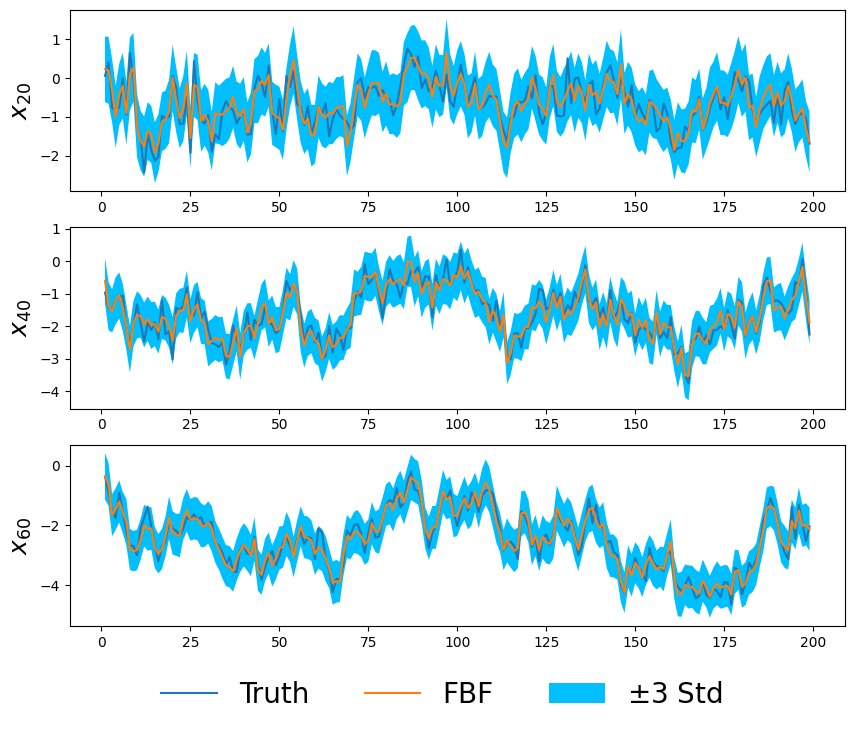

In [7]:
########################################################
############## Plot Confidence Interval ################
########################################################
x_P_plus = Calc_sample_covariance(x_ensemble_sample)

def visualize_confidence_interval_temporal(T, true_state, x_ensemble_sample, x_P_plus):
    x1_mean = x_ensemble_sample[..., 20].mean(1)
    x2_mean = x_ensemble_sample[..., 40].mean(1)
    x3_mean = x_ensemble_sample[..., 60].mean(1)

    x1_std = np.sqrt(x_P_plus[..., 20, 20])
    x2_std = np.sqrt(x_P_plus[..., 40, 40])
    x3_std = np.sqrt(x_P_plus[..., 60, 60])
    x1_lb = x1_mean - 3 * x1_std
    x1_ub = x1_mean + 3 * x1_std
    x2_lb = x2_mean - 3 * x2_std
    x2_ub = x2_mean + 3 * x2_std
    x3_lb = x3_mean - 3 * x3_std
    x3_ub = x3_mean + 3 * x3_std
    
    plt.style.use('default')
    fig = plt.figure(figsize=(10, 8))

    ax = fig.add_subplot(3, 1, 1)
    ax.plot(range(1, T), true_state[:, 20], label='Truth')
    ax.plot(range(1, T), x1_mean, label='FBF')
    ax.set_ylabel(r'$x_{20}$', fontsize=18)
    plt.fill_between(range(1, T), x1_lb, x1_ub, facecolor='deepskyblue', label=r'$\pm 3$' + ' Std')

    ax = fig.add_subplot(3, 1, 2)
    ax.plot(range(1, T), true_state[:, 40], label='Truth')
    ax.plot(range(1, T), x2_mean, label='FBF')

    ax.set_ylabel(r'$x_{40}$', fontsize=18)
    plt.fill_between(range(1, T), x2_lb, x2_ub, facecolor='deepskyblue', label=r'$\pm 3$' + ' Std')
    
    ax = fig.add_subplot(3, 1, 3)
    ax.plot(range(1, T), true_state[:, 60], label='Truth')
    ax.plot(range(1, T), x3_mean, label='FBF')
    ax.set_ylabel(r'$x_{60}$', fontsize=18)
    plt.fill_between(range(1, T), x3_lb, x3_ub, facecolor='deepskyblue', label=r'$\pm 3$' + ' Std')

    ax.legend(loc='upper center', bbox_to_anchor=(0.48, -0.165), ncol=3, frameon=False, fontsize=20)
    
x_P_plus = Calc_sample_covariance(x_ensemble_sample)
visualize_confidence_interval_temporal(Nt, x_true_value, x_ensemble_sample, x_P_plus)

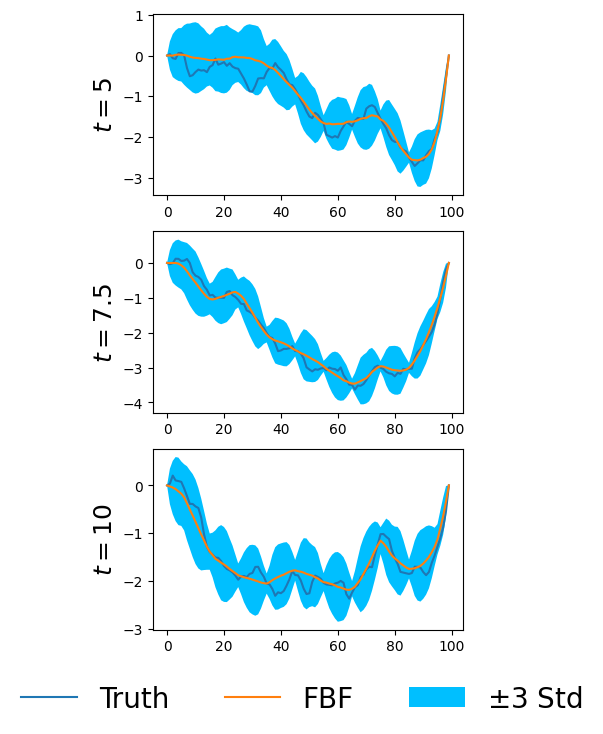

In [8]:
def visualize_confidence_interval_spatial(T, true_state, x_ensemble_sample, x_P_plus):
    Nx = true_state.shape[1]
    t1_mean = x_ensemble_sample[99].mean(0)
    t2_mean = x_ensemble_sample[149].mean(0)
    t3_mean = x_ensemble_sample[198].mean(0)

    t1_std = x_ensemble_sample[99].std(0)
    t2_std = x_ensemble_sample[149].std(0)
    t3_std = x_ensemble_sample[198].std(0)
    
    t1_lb = t1_mean - 3 * t1_std
    t1_ub = t1_mean + 3 * t1_std
    t2_lb = t2_mean - 3 * t2_std
    t2_ub = t2_mean + 3 * t2_std
    t3_lb = t3_mean - 3 * t3_std
    t3_ub = t3_mean + 3 * t3_std
    
    plt.style.use('default')
    fig = plt.figure(figsize=(4, 8))

    ax = fig.add_subplot(3, 1, 1)
    ax.plot(range(Nx), true_state[99], label='Truth')
    ax.plot(range(Nx), t1_mean, label='FBF')
    ax.set_ylabel(r'$t = 5$', fontsize=18)
    plt.fill_between(range(Nx), t1_lb, t1_ub, facecolor='deepskyblue', label=r'$\pm 3$' + ' Std')

    ax = fig.add_subplot(3, 1, 2)
    ax.plot(range(Nx), true_state[149], label='Truth')
    ax.plot(range(Nx), t2_mean, label='FBF')

    ax.set_ylabel(r'$t = 7.5$', fontsize=18)
    plt.fill_between(range(Nx), t2_lb, t2_ub, facecolor='deepskyblue', label=r'$\pm 3$' + ' Std')
    
    ax = fig.add_subplot(3, 1, 3)
    ax.plot(range(Nx), true_state[198], label='Truth')
    ax.plot(range(Nx), t3_mean, label='FBF')
    
    ax.set_ylabel(r'$t = 10$', fontsize=18)
    plt.fill_between(range(Nx), t3_lb, t3_ub, facecolor='deepskyblue', label=r'$\pm 3$' + ' Std')

    ax.legend(loc='upper center', bbox_to_anchor=(0.48, -0.165), ncol=3, frameon=False, fontsize=20)
    
x_P_plus = Calc_sample_covariance(x_ensemble_sample)
visualize_confidence_interval_spatial(Nt, x_true_value, x_ensemble_sample, x_P_plus)

# evaluation

In [13]:
def Calc_root_mean_square_error(s_true, s_pred):
    N_s = s_true.shape[1]
    return np.sqrt((np.linalg.norm(s_true - s_pred, 2, axis=1) ** 2).mean()/N_s)

def Calc_sample_covariance(s_ensemble_sample):
    ensemble_size = s_ensemble_sample.shape[1] # (T, N_ensemble, m)
    s_mean = s_ensemble_sample.mean(axis=1, keepdims=True)
    s_dev = s_ensemble_sample - s_mean
    return 1 / (ensemble_size - 1) * np.matmul(s_dev.transpose(0, 2, 1), s_dev)

def Calc_spread(s_ensemble_sample):
    N_s = s_ensemble_sample.shape[2]
    P_plus = Calc_sample_covariance(s_ensemble_sample)
    Tr_P_plus = np.array([np.trace(P_plus[i]) for i in range(len(P_plus))])
    return np.sqrt(Tr_P_plus.mean()/N_s)

def FBF_Rmse_test_set(x_test, y_test):
    print("Filtering over all test sets ...")
    print("Calculating Rmse ...")
    ensemble_size = 500
    Rmse_test = np.zeros(N_test)
    pbar = trange(N_test)
    for i in pbar:
        s_true = x_test[i][1:Nt].cpu().detach().numpy()
        data = y_test[i][0:Nt]
        s_ensemble_sample = model.calc_ensemble(ensemble_size, data.to(device), SAD, device).cpu().detach().numpy()
        s_pred = s_ensemble_sample.mean(1)
        Rmse_test[i] = Calc_root_mean_square_error(s_true, s_pred)
    return Rmse_test

In [14]:
# RMSE
Rmse_test = FBF_Rmse_test_set(x_test, y_test)

print("Mean Rmse over test set:", Rmse_test.mean())
print("std:", Rmse_test.std())

Filtering over all test sets ...
Calculating Rmse ...


100%|███████████████████████████████| 200/200 [05:00<00:00,  1.50s/it]

Mean Rmse over test set: 0.2205546044677541
std: 0.004858856414671775
